In [246]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import sys
import itertools
from scipy.ndimage import gaussian_filter1d
import glob
sys.path.append("D:/ryanh/github/ripple_analyses")
from functions import *

In [244]:
def get_raster_points(spikes,peak_time):
    ''' 
    create raster centered over each ripple with a 1 second window
    '''
    x = []
    y = []
    for i,r in enumerate(peak_time):
        idx = (spikes> r - .5) & (spikes < r + .5)
        cur_spks = spikes[idx]
        if any(cur_spks):
            x.append(cur_spks - r)
            y.append(np.ones_like(cur_spks)+i)       
    x = list(itertools.chain(*x))
    y = list(itertools.chain(*y))
    return x, y

def get_h0_z_energy(x,y,binsize=0.005,window=30):
     # bin cell into 5ms bins 
    h0_counts, bin_edges = np.histogram(x, bins=np.arange(-0.5,0.5,binsize))
    # normalize into firing rate
    h0 = h0_counts / (len(np.unique(y))*binsize)
    # smooth to get expected firing rate
    hist_smooth = gaussian_filter1d(h0,window)
    # subtract the expected rates and devided by the standard deviation to get z-scored modulation
    z = (h0 - hist_smooth) / np.sqrt(hist_smooth)
    # Calculate the amplitude of the SWR modulation
    swr_energy = np.sqrt(sum(z**2))
    return h0, z, swr_energy, h0_counts

def get_good_channels(shank):
    #extract values from dictionary
    an_array = np.array(list(shank.values()),dtype=object)
    
    #loop through array to pull out individual channel        
    good_ch = []
    for i in range(len(an_array)):
        for x in range(len(an_array[i])):
            good_ch.append(an_array[i][x])
        
    return good_ch

In [98]:
df_cell_class = pd.read_csv('F:/Projects/PAE_PlaceCell/analysis/ripple_modulation/post_processed/pyr_int_df.csv')
df_swr = pd.read_csv('F:/Projects/PAE_PlaceCell/analysis/swr_data/post_processed/swr_df.csv')

with open(r'F:\Projects\PAE_PlaceCell\analysis\ripple_modulation\post_processed\mod_dict.pkl', 'rb') as f:
        mod_dict = pickle.load(f)
        
# df_cell_class_all = pd.read_csv('F:/Projects/PAE_PlaceCell/analysis/cell_recruitment/processed/pyr_int_df.csv')

data_path = 'F:/Projects/PAE_PlaceCell/ProcessedData/'

In [99]:
df_cell_class['ripple_mod'] = (df_cell_class.hi_pass == True) | (df_cell_class.low_pass == True)
df_cell_class['good_cells'] = (df_cell_class.n_ripples >= 50) & (df_cell_class.n_spikes >= 100)

In [445]:
potential_cells_df = df_cell_class[((df_cell_class.ripple_mod == False) &
               df_cell_class.good_cells &
               (df_cell_class.n_spikes_in_rip_window > 200) &
               (df_cell_class.group == "pae") &
               (df_cell_class.area == "ca1") &
               (df_cell_class.cell_type == "int"))]


In [ ]:
# curr_cell = 4
# curr_cell = 9
# curr_cell = 12
# curr_cell = 21

# LEM3124_S20190302163218 TT3.mat 6
# LS19_S20170508130713 TT6.mat 2
# LEM3124_S20190401125222 TT5.mat 2
# curr_cell = np.where((potential_cells_df.session == 'LEM3124_S20190302163218') & (potential_cells_df.tetrode == 'TT3.mat') & (potential_cells_df.cell == 6))[0][0]
# curr_cell = np.where((potential_cells_df.session == 'LS19_S20170508130713') & (potential_cells_df.tetrode == 'TT6.mat') & (potential_cells_df.cell == 2))[0][0]
# curr_cell = np.where((potential_cells_df.session == 'LEM3124_S20190401125222') & (potential_cells_df.tetrode == 'TT5.mat') & (potential_cells_df.cell == 2))[0][0]


def plot_raster_example(potential_cells_df,curr_cell,df_cell_class,df_swr,axs):
    
    session = potential_cells_df.session.iloc[curr_cell]
    tetrode = potential_cells_df.tetrode.iloc[curr_cell]
    cell = potential_cells_df.cell.iloc[curr_cell]
    print(session,tetrode,cell)

    curr_session_df = df_cell_class[(df_cell_class.session == session)]    

    cell_idx = np.where((curr_session_df.tetrode == tetrode) & (curr_session_df.cell == cell))[0][0]

    # find index of first mention of session
    rip_n = np.where(df_swr.session == session)[0][0]
    # load spikes
    spikes = np.load('F:/Projects/PAE_PlaceCell/analysis/spikes/'+df_swr.iloc[rip_n].session+'.npy',allow_pickle=True)
    # get ripple times
    peak_time = df_swr.peak_time[df_swr.session == session]
    event = df_swr[df_swr.session == session]


    binsize=0.005
    window=30
    x, y = get_raster_points(spikes[cell_idx],peak_time)
    h0, z, swr_energy, h0_counts = get_h0_z_energy(x,y,binsize=binsize,window=window)

    axs[0].axvline(0, linestyle = '--', linewidth = 1, alpha = 0.5, color = 'grey')
    axs[0].plot(x,y,'|',color='k',markersize=1,mew = 0.5)
    axs[0].set_ylabel('ripple #')
    axs[0].set_xticks([], [])
    axs[0].set_yticks([int(np.max(y))])

    axs[1].axvline(0, linestyle = '--', linewidth = 1, alpha = 0.5, color = 'grey')
    axs[1].bar(np.linspace(-0.5,0.5,len(h0)), h0, color='black',width=0.006)
    axs[1].set_ylabel('firing rate (Hz)')
    axs[1].set_xlabel('time lag (sec)')

    axs[0].set_xlim(-0.5,0.5)
    axs[1].set_xlim(-0.5,0.5)

    for i in range(2):
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        
    return session,tetrode,cell

for curr_cell in range(len(potential_cells_df)):
    fig, axs = plt.subplots(2,1, figsize=set_size('thesis', fraction=.3, subplots=(2,1)), edgecolor='k')
    fig.subplots_adjust(hspace = 0.1, wspace=0)
    axs = axs.ravel()
    session,tetrode,cell = plot_raster_example(potential_cells_df,curr_cell,df_cell_class,df_swr,axs)
    plt.savefig('F:/Projects/PAE_PlaceCell/analysis/ripple_modulation/post_processed/examples/'+session+tetrode+str(cell)+'.png',dpi=150,bbox_inches='tight')


LEM3124_S20190302163218 TT3.mat 6


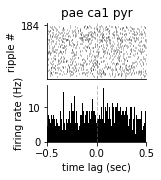

In [442]:
curr_cell = np.where((potential_cells_df.session == 'LEM3124_S20190302163218') & (potential_cells_df.tetrode == 'TT3.mat') & (potential_cells_df.cell == 6))[0][0]
# curr_cell = np.where((potential_cells_df.session == 'LS19_S20170508130713') & (potential_cells_df.tetrode == 'TT6.mat') & (potential_cells_df.cell == 2))[0][0]
# curr_cell = np.where((potential_cells_df.session == 'LEM3124_S20190401125222') & (potential_cells_df.tetrode == 'TT5.mat') & (potential_cells_df.cell == 2))[0][0]

fig, axs = plt.subplots(2,1, figsize=set_size('thesis', fraction=.3, subplots=(2,1)), edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0)
axs = axs.ravel()
plot_raster_example(potential_cells_df,curr_cell,df_cell_class,df_swr,axs)
axs[0].set_title('pae ca1 pyr')
plt.savefig('D:/ryanh/GoogleDrive/school_work/UNM/Lab/Projects/Dissertation/dissertation/inkscape_figs/ripple_recuitment/mod_examples/pae_ca1_pyr.svg',dpi=300,bbox_inches='tight')


LS19_S20170508130713 TT1.mat 8


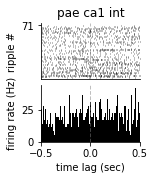

In [447]:
fig, axs = plt.subplots(2,1, figsize=set_size('thesis', fraction=.3, subplots=(2,1)), edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0)
axs = axs.ravel()

curr_cell = np.where((potential_cells_df.session == 'LS19_S20170508130713') & (potential_cells_df.tetrode == 'TT1.mat') & (potential_cells_df.cell == 8))[0][0]

plot_raster_example(potential_cells_df,curr_cell,df_cell_class,df_swr,axs)
axs[0].set_title('pae ca1 int')
plt.savefig('D:/ryanh/GoogleDrive/school_work/UNM/Lab/Projects/Dissertation/dissertation/inkscape_figs/ripple_recuitment/mod_examples/pae_ca1_int.svg',dpi=300,bbox_inches='tight')


# LS19_S20170508130713 TT1.mat 8

In [408]:
from neurodsp.filt import filter_signal

path = get_session_path(data_path+session+'.mat')
# load xml which has channel & fs info
channels,fs,shank = loadXML(path)
# get good channels
good_ch = get_good_channels(shank)

lfp,lfp_ts = loadLFP(glob.glob(path +'\*.lfp')[0], n_channels=channels,
                 channel=good_ch, frequency=fs)

lfp = np.stack([filter_signal(lfp_,fs,'bandpass',(80,250),remove_edges=False) for lfp_ in lfp.T])
lfp = lfp.T
# del lfp

# # current lfp
# current_lfp = lfp[(lfp_ts > start) & (lfp_ts < end),event.peak_channel]
# current_lfp_ts = lfp_ts[(lfp_ts > start) & (lfp_ts < end)]

current_lfp = []
current_lfp_ts = []

for ripple in event.itertuples():
#     idx = (lfp_ts > ripple.peak_time - .5) & (lfp_ts < ripple.peak_time + .5)
    center_idx = np.where(lfp_ts >= ripple.peak_time)[0][0] 

    current_lfp.append(lfp[int(center_idx - fs/2):int(center_idx + fs/2),ripple.peak_channel])
    current_lfp_ts.append(lfp_ts[int(center_idx - fs/2):int(center_idx + fs/2)])

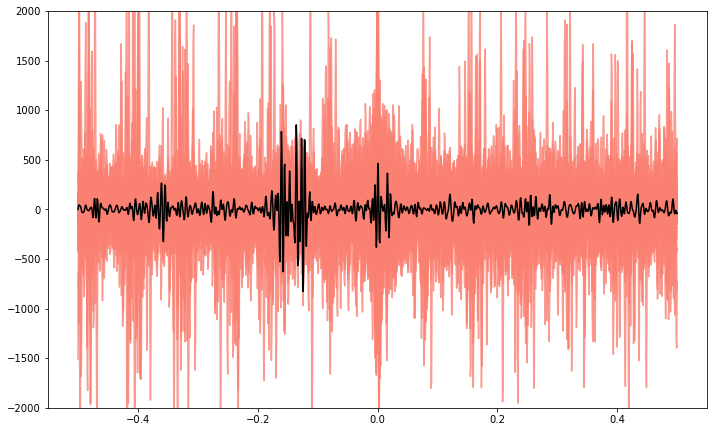

In [415]:
from scipy import stats
# X = stats.zscore(np.vstack(current_lfp))
X = np.vstack(current_lfp)

plt.figure(figsize=set_size('thesis', fraction=2, subplots=(1,1)))
# fig, axs = plt.subplots(2,1, figsize=set_size('thesis', fraction=.5, subplots=(2,1)), edgecolor='k')

plt.plot(np.linspace(-.5,.5,X.shape[1]),X.T,color='salmon',alpha=.8)
plt.plot(np.linspace(-.5,.5,X.shape[1]),X[3],color='k',alpha=1)

# plt.xlim(-0.2,0.2)
plt.ylim(-2000,2000)

# plt.plot(X.T+np.linspace(0,100000,X.shape[0]),color='salmon',alpha=.8)
# plt.plot(np.mean(X,axis=0),color='k')
# plt.plot(X[1])
# plt.ylim(-50,50)
# plt.axis('off')
plt.show()

# plt.savefig('F:/Projects/PAE_PlaceCell/analysis/ripple_modulation/post_processed/examples/'+session+tetrode+str(cell)+'.png',dpi=150,bbox_inches='tight')

# plt.figure(figsize=(10,10))
# plt.imshow(X,aspect='auto',vmin=-100,vmax=100)
# plt.show()

In [221]:
def shuff_spikes(s,session_range,n_shuff=400):
    '''
    shuffles spike train by -+ session duration
    '''
    # find random uniform intervals to shift spike times
    surrogate = np.random.choice(np.arange(-session_range[1],session_range[1]), size=n_shuff,replace=False)
    shuff_spks = []
    for n in surrogate:
        # offset spike times
        new_s = s + n
        # wrap spike times that are outside the range of session
        if np.any(new_s > session_range[1]):
            idx = new_s > session_range[1]
            new_s = np.hstack([new_s[idx] - min(new_s[idx]),new_s[idx==False]])
        elif np.any(new_s < session_range[0]):
            idx = new_s < session_range[0]
            new_s = np.hstack([new_s[idx==False],new_s[idx] + max(new_s) + -n])

        shuff_spks.append(new_s)
    return shuff_spks

def find_consecutive(L,length=4):
    '''
    gives true or false if binary vector L has consective 1s for at 
    least length n (default=4)
    '''
    grouped_L = [(k, sum(1 for i in g)) for k,g in groupby(L)]
    grouped_L

    n_contig = []
    for item in grouped_L:
        if item[0] == 1:
            n_contig.append(item[1])  
    return np.any(np.array(n_contig) >= length)

def surrogate_test(s,h0,session_range,peak_time,conf=95):
    '''
    shuffle methods from Oliva et al. 2016 to find significant ripple modulation
    of individual units
    '''
    
    shuff_spks = shuff_spikes(s,session_range)

    null = []
    for new_s in shuff_spks:
        x, y = get_raster_points(new_s, peak_time)
        cur_h0, _, _, _ = get_h0_z_energy(x,y)
        null.append(cur_h0)

    null = np.array(null)
    shuff_hibound = np.percentile(null, conf, axis=0)
    shuff_lobound = np.percentile(null, 100-conf, axis=0)
    
    hi_pass = find_consecutive((h0 > shuff_hibound) * 1)
    low_pass = find_consecutive((h0 < shuff_lobound) * 1)
    
    return hi_pass,low_pass,shuff_hibound,shuff_lobound
from itertools import groupby

spikes_ = list(itertools.chain(*spikes))
session_range = [min(spikes_),max(spikes_)]
hi_pass, low_pass, shuff_hibound, shuff_lobound = surrogate_test(spikes[cell_idx],h0,session_range,peak_time)
hi_pass

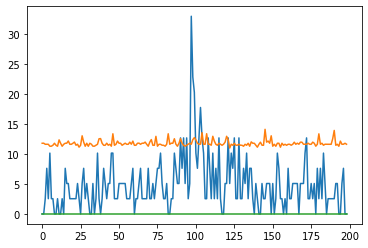

In [225]:
plt.plot(h0)
plt.plot(shuff_hibound)
plt.plot(shuff_lobound)

In [ ]:
def swr_modulation(spikes,peak_time,binsize=0.005):
    # create raster centered over each ripple with a 1 second window
    x = []
    y = []
    for i,r in enumerate(peak_time):
        idx = (spikes> r - .5) & (spikes < r + .5)
        cur_spks = spikes[idx]
        if any(cur_spks):
            x.append(cur_spks - r)
            y.append(np.ones_like(cur_spks)+i)       
    x = list(itertools.chain(*x))
    y = list(itertools.chain(*y))

    # bin cell into 5ms bins 
    h0, bin_edges = np.histogram(x, bins=np.arange(-0.5,0.5,binsize))
    # normalize into firing rate
    h0 = h0 / (len(np.unique(y))*binsize)
    # smooth to get expected firing rate
    hist_smooth = gaussian_filter1d(h0,30)
    # subtract the expected rates and devided by the standard deviation to get z-scored modulation
    z = (h0 - hist_smooth) / np.sqrt(hist_smooth)
    # Calculate the amplitude of the SWR modulation
    swr_energy = np.sqrt(sum(z**2))
    return h0, z, swr_energy, x, y

cell_n = 6
# display(df_cell_class[df_cell_class.session == session].iloc[cell_n])

# loop through each cell and get modulation 
hist, z_hist, swr_energy, x, y = swr_modulation(spikes[cell_n],peak_time)

fig, axs = plt.subplots(2,2, figsize=set_size('thesis', fraction=.5, subplots=(2,2)), edgecolor='k')
fig.subplots_adjust(hspace = 0.2, wspace=0.4)
axs = axs.ravel()

axs[0].plot(x,y,'|',color='black',markersize=1,mew = 0.5,rasterized=True)
axs[0].set_ylabel("SWR\nevents",  multialignment='center',  labelpad = 1)
axs[0].set_xticks([], [])
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
axs[0].get_xaxis().tick_bottom()
axs[0].get_yaxis().tick_left()
axs[0].set_xlim(-.5,.5)
axs[0].set_title('Interneuron')

axs[2].plot(np.linspace(-0.5,0.5,len(hist)), hist, color='black',linewidth = 1)
axs[2].set_ylabel('Firing rate \n(Hz)', verticalalignment = 'bottom')
axs[2].axvline(0,linestyle = '--', color = 'grey', linewidth = 0.5)
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].get_xaxis().tick_bottom()
axs[2].get_yaxis().tick_left()
axs[2].set_xlim(-.5,.5)
axs[2].set_xlabel('Time From SWRs (s)')


cell_n = 2
# display(df_cell_class[df_cell_class.session == session].iloc[cell_n])

# loop through each cell and get modulation 
hist, z_hist, swr_energy, x, y = swr_modulation(spikes[cell_n],peak_time)

axs[1].plot(x,y,'|',color='black',markersize=1,mew = 0.5,rasterized=True)
# axs[1].set_ylabel("SWR\nevents",  multialignment='center',  labelpad = 1)
axs[1].set_xticks([], [])
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].get_xaxis().tick_bottom()
axs[1].get_yaxis().tick_left()
axs[1].set_xlim(-.5,.5)
axs[1].set_title('Pyramidal cell')


axs[3].plot(np.linspace(-0.5,0.5,len(hist)), hist, color='black',linewidth = 1)
# axs[3].set_ylabel('Firing rate (Hz)', verticalalignment = 'bottom')
axs[3].axvline(0,linestyle = '--', color = 'grey', linewidth = 0.5)
axs[3].spines['top'].set_visible(False)
axs[3].spines['right'].set_visible(False)
axs[3].get_xaxis().tick_bottom()
axs[3].get_yaxis().tick_left()
axs[3].set_xlim(-.5,.5)